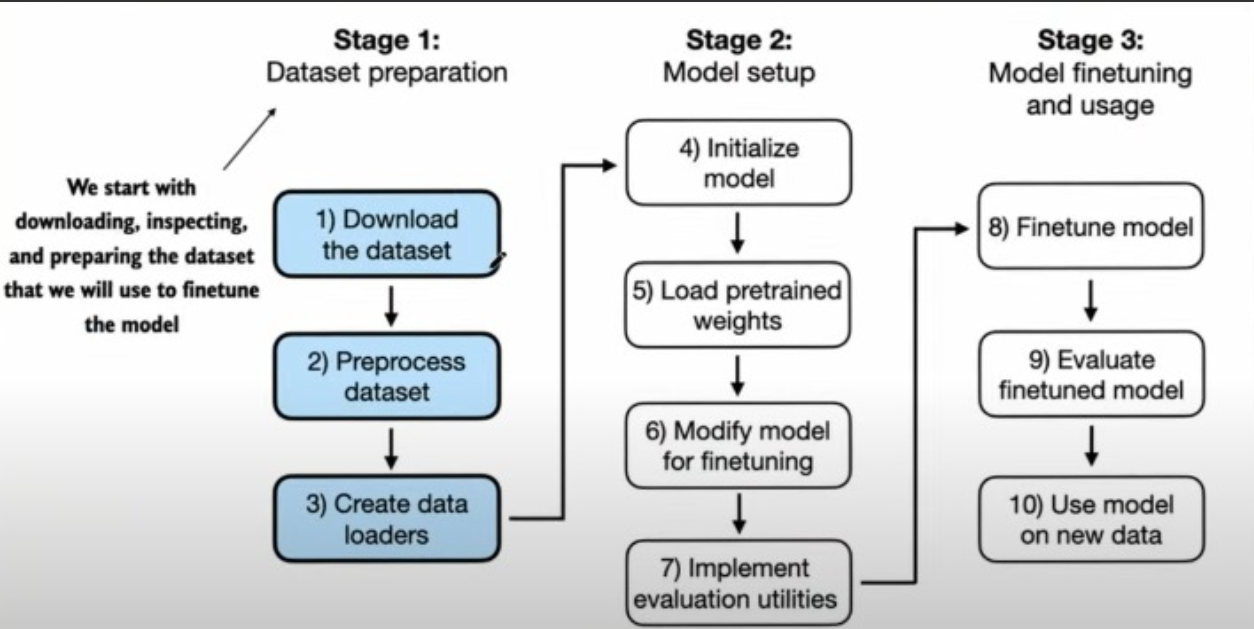

# FINETUNING FOR CLASSIFICATION

* 1) Loading Dataset and Preprocessing Dataset

In [1]:
import pandas as pd
df = pd.read_csv(
    "spam.csv",
    encoding='latin1',
    usecols=[0, 1],       # first column = label, second column = message
    names=["v1", "v2"],   # rename columns
    header=0              # first row is the header
)
print(df["v1"].value_counts())

v1
ham     4825
spam     747
Name: count, dtype: int64


In [2]:
def createBalancedDataset(df):
    spamCount = df[df["v1"] == "spam"].shape[0]
    notSpamSubset = df[df["v1"] == "ham"].sample(spamCount, random_state=123)  # sample same number of ham
    balancedDf = pd.concat([notSpamSubset, df[df["v1"] == "spam"]], ignore_index=True)
    balancedDf = balancedDf.sample(frac=1, random_state=123).reset_index(drop=True)
    return balancedDf
balancedDf = createBalancedDataset(df)
print(balancedDf["v1"].value_counts())


v1
ham     747
spam    747
Name: count, dtype: int64


In [3]:
balancedDf["v1"] = balancedDf["v1"].map({"ham":0, "spam":1})
print(balancedDf.head())

   v1                                                 v2
0   0                                      \alright babe
1   0  A guy who gets used but is too dumb to realize...
2   1  Reminder: You have not downloaded the content ...
3   1  Got what it takes 2 take part in the WRC Rally...
4   1  Shop till u Drop, IS IT YOU, either 10K, 5K, å...


* Splitting dataset
70% Training
10% Validation
20% testing

* Validation Data: Used to tune hyperparameters and check the model during training. Hyperparameters include learning rate, number of layers, dropout rate, batch size, etc. The model does not learn from validation data. It is only used to measure how well the model generalizes to unseen data during training.

In [4]:
def randomSplit(df, trainingFraction, validationFraction):
  df = df.sample(frac = 1, random_state = 123).reset_index(drop = True)
  trainingEnd = int(len(df)*trainingFraction)
  validationEnd = trainingEnd + int(len(df)*validationFraction)
  training = df.iloc[:trainingEnd]
  validation = df.iloc[trainingEnd:validationEnd]
  test = df.iloc[validationEnd:]
  return training, validation, test
trainingDf, validationDf, testingDf = randomSplit(balancedDf, 0.7, 0.1)

In [5]:
print(len(trainingDf))
print(len(validationDf))
print(len(testingDf))

1045
149
300


In [6]:
trainingDf.to_csv("training.csv", index=False)
validationDf.to_csv("validation.csv", index=False)
testingDf.to_csv("testing.csv", index=False)

* 2) Creating DataLoaders
Input Text --> Tokenize --> Convert All sentences to same length(padding with <|endoftext>|


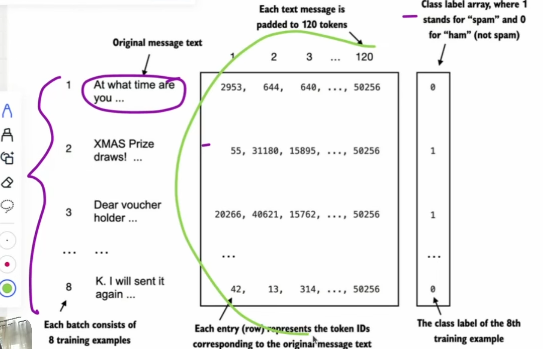

In [11]:
import importlib
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

* Dataset Creation

In [20]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, maxLen=None, padTokenId=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["v2"]
        ]
        if maxLen is None:
            self.maxLen = max(len(text) for text in self.encoded_texts)
        else:
            self.maxLen = maxLen
            self.encoded_texts = [
                encoded_text[:self.maxLen] for encoded_text in self.encoded_texts
            ]
        # Padding
        self.encoded_texts = [
            encoded_text + [padTokenId] * (self.maxLen - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["v1"]   # label column is v1
        return torch.tensor(encoded), torch.tensor(label)

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        return max(len(text) for text in self.encoded_texts)


In [21]:
trainingDataset = SpamDataset(
    csv_file = "training.csv",
    maxLen = None,
    tokenizer = tokenizer
)
print(trainingDataset.maxLen)

103


In [24]:
validationDataset = SpamDataset(
    csv_file = "validation.csv",
    maxLen = trainingDataset.maxLen,
    tokenizer = tokenizer
)

testingDataset = SpamDataset(
    csv_file = "testing.csv",
    maxLen = trainingDataset.maxLen,
    tokenizer = tokenizer
)
print(validationDataset.maxLen)
print(testingDataset.maxLen)

103
103


* DataLoader Creation

In [28]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

trainingLoader = DataLoader(
    dataset=trainingDataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True  # drop incomplete batch
)

validationLoader = DataLoader(
    dataset=validationDataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

testingLoader = DataLoader(
    dataset=testingDataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

In [30]:
print("Train Loader")
for inputBatch, TargetBatch in trainingLoader:
  pass
print(inputBatch.shape)  # Tokenized SMS
print(TargetBatch.shape) # Labels

print(len(trainingLoader))
print(len(validationLoader))
print(len(testingLoader))

Train Loader
torch.Size([8, 103])
torch.Size([8])
130
19
38
